# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# 1. Loading Libraries

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as ss
import prettytable
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn import preprocessing
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import roc_curve,roc_auc_score,auc
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import cross_validate
import re # Go to https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os

/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
#Loading the dataset that we cleaned in TSNE project
df = pd.read_csv('affrd_cleaned_preprocessed.csv')

In [ ]:
df['Score'].value_counts() #counting the number of positive and negative datapoints

In [3]:
#randomly sampling positive and negative datapoints and from the dataframe 'df' and creating new data frame total_points
#positive_points = df[df['Score'] == 'positive'].sample(n=50000, random_state=0)#randomly sampling 20k positive points
#negative_points = df[df['Score'] == 'negative'].sample(n=50000, random_state=0)# randomly sampling 20k negative points
#total_points = pd.concat([positive_points, negative_points])#concatenating the positive_points and negative_points dataframe

# Sorting based on time
#sorted_data = total_points.sort_values('Time', #Here we are sorting filtered_data according to Time in 
#                                        axis = 0,    #- ascending order so that we can do time based splitting later.
#                                     inplace = False, #inpace = false because we dont want to make modifications in-
                                      #- fitered data rather we want to keep filtered_data preserved and store the modified-
                                      #- data in sorted_data
#                                    kind = 'quicksort',
#                                     na_position = 'last')
#sorted_data['Score'].value_counts()
#sorted_data.to_csv('sorted_data_df.csv')
sorted_data = pd.read_csv('sorted_data_df.csv')

In [4]:
sorted_data.shape

(100000, 13)

In [5]:
#storing my 'cleaned text' column in d_train into datapoint matrix x_train and 'Score' column in d_train into y_train-
#- and similar thing we are doing for, d_cv and d_test
d_train = sorted_data.iloc[0:60000] #taking top 60k data points from sorted_data and storing it in d_train
d_cv = sorted_data.iloc[60000:80000]#taking next 20k data points from sorted_data and storing it in d_cv
d_test = sorted_data.iloc[80000:100000]#taking last 20k data points from sorted_data and storing it in d_test

In [6]:
#Storing 'CleanedText' and 'Score' columns in d_train into x_train and y_train respectively and doing the same for d_cv and-
#-d_test
x_train = d_train['CleanedText']
x_cv = d_cv['CleanedText']
x_test = d_test['CleanedText']
y_train = d_train['Score']
y_cv = d_cv['Score']
y_test = d_test['Score']

In [7]:
#changing 'negative' to 0 and 'positive' to 1 in y_train and binarizing the elements in y_train such that now-
#- 1 will represent positive points and 0 will represent negative points
lb = preprocessing.LabelBinarizer()
list_1 = []
for i in y_train:
    if i == 'negative':
        list_1.append(0)
    else:
        list_1.append(1)
a = pd.DataFrame(list_1)
y_train = a
lb.fit(y_train)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [8]:
#changing 'negative' to 0 and 'positive' to 1 in y_cv and binarizing the elements in y_cv such that now-
#- 1 will represent positive points and 0 will represent negative points
lb = preprocessing.LabelBinarizer()
list_1 = []
for i in y_cv:
    if i == 'negative':
        list_1.append(0)
    else:
        list_1.append(1)
a = pd.DataFrame(list_1)
y_cv = a
lb.fit(y_cv)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [9]:
#changing 'negative' to 0 and 'positive' to 1 in y_test and binarizing the elements in y_test such that now-
#- 1 will represent positive points and 0 will represent negative points
list_1 = []
for i in y_test:
    if i == 'negative':
        list_1.append(0)
    else:
        list_1.append(1)
a = pd.DataFrame(list_1)
y_test = a
lb.fit(y_test)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [10]:
y_train.shape

(60000, 1)

In [11]:
y_train= np.ravel(y_train)
y_cv= np.ravel(y_cv)
y_test= np.ravel(y_test)

In [12]:
y_train.shape

(60000,)

# 2. Bag of words (BOW)

In [13]:
#Bag of words
#Applying Bag of words on train datapoint dataset 'x_train'
vectorizer = CountVectorizer(min_df = 50) #defining our BOW model here. Here we are considering words which occur more than-
#-50 times in our document.
model = vectorizer.fit(x_train)#learning the internal parameters (here vocabulary) of text(i.e reviews) in x_train
print(vectorizer.vocabulary_) #visulaizing the vocabulary

{'paprika': 1924, 'unusu': 2892, 'edit': 847, 'stimul': 2579, 'absolut': 2, 'broken': 317, 'becam': 215, 'ingredi': 1391, 'taken': 2687, 'dill': 744, 'veget': 2920, 'ago': 50, 'seven': 2371, 'up': 2893, 'fizzi': 1024, 'cramp': 613, 'lesson': 1549, 'compromis': 545, 'graham': 1174, 'firm': 1016, 'cant': 381, 'scratch': 2332, 'savor': 2315, 'elder': 854, 'whos': 3005, 'tag': 2684, 'great': 1193, 'tip': 2778, 'line': 1566, 'begin': 223, 'night': 1804, 'bare': 194, 'dump': 820, 'spent': 2519, 'section': 2344, 'non': 1808, 'crash': 616, 'itll': 1434, 'usda': 2900, 'credit': 624, 'heinz': 1275, 'tradit': 2819, 'stick': 2574, 'lip': 1569, 'altern': 78, 'deliveri': 702, 'regul': 2185, 'bakeri': 183, 'vari': 2914, 'hungri': 1335, 'health': 1259, 'bear': 212, 'mini': 1710, 'load': 1581, 'hour': 1324, 'sweeter': 2667, 'tapioca': 2695, 'still': 2578, 'donat': 787, 'friski': 1089, 'medicin': 1673, 'brush': 323, 'determin': 725, 'green': 1197, 'job': 1452, 'calor': 365, 'unus': 2891, 'tsp': 2848, 'd

In [14]:
train_bow = model.transform(x_train)#converting the internal parameters(i.e vocab) into vectors
cv_bow = model.transform(x_cv)# using the same vocab of x_train I am transforming the text in x_cv into bow matrix-
#- in order to maintain the same dimension of matrix as train_bow
test_bow = model.transform(x_test)# using the same vocab of x_train I am transforming the text in x_test into bow matrix-
#- in order to maintain the same dimension of matrix as train_bow

In [15]:
#here we are creating a dataframe out of train_bow,cv_bow and test_bow
train_bow_df = pd.DataFrame(train_bow.toarray(),columns = model.get_feature_names())
cv_bow_df = pd.DataFrame(cv_bow.toarray(),columns = model.get_feature_names())
test_bow_df = pd.DataFrame(test_bow.toarray(),columns = model.get_feature_names())

In [16]:
#Here we are standardizing dataframes train_bow_df, cv_bow_df and test_bow_df
standardized_train = StandardScaler().fit_transform(train_bow_df)
standardized_cv = StandardScaler().fit_transform(cv_bow_df)
standardized_test = StandardScaler().fit_transform(test_bow_df)

In [17]:
standardized_train.shape

(60000, 3085)

## [2.1] Logistic Regression on BOW

### [2.1.1] Applying Logistic Regression with L1 regularization on BOW

In [18]:
#Here we are trying to find area under AUC score along with Confusion matrix for train dataset for various values of-
#- C using Logistic Regression
train_roc = []
C = [10**6,10**5,10**4,10**3,10**2,10,1,10**-1,10**-2,10**-3,10**-4,10**-5,10**-6]
for i in C:
    lr = LogisticRegression(penalty = 'l1',C=i)
    lr.fit(standardized_train,y_train)
    pred = lr.predict(standardized_train)
    train_roc.append(roc_auc_score(y_train, pred))#roc_auc_score calculates area under the roc curve 

In [19]:
#performing simple cross validation using Logistic Regression for various values of C. Our metrics are-
#- area under auc curve and Confusion matrix
cv_roc = []
C = [10**6,10**5,10**4,10**3,10**2,10,1,10**-1,10**-2,10**-3,10**-4,10**-5,10**-6]
for i in C:
    lr = LogisticRegression(penalty = 'l1',C=i)
    lr.fit(standardized_train,y_train)
    pred = lr.predict(standardized_cv)
    cv_roc.append(roc_auc_score(y_cv, pred))
    co_mt = confusion_matrix(y_cv,pred)
    TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100# calculating TNR, TPR, FPR, FNR
    FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
    TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
    FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100  
    print('\nFor C = {0}, the area under AUC curve is = {1}, the TPR = {2}, TNR = {3}, FPR = {4}, FNR = {5}'.format(i,roc_auc_score(y_cv, pred),TPR,TNR,FPR,FNR))


For C = 1000000, the area under AUC curve is = 0.8660809178743961, the TPR = 90.27173913043478, TNR = 82.94444444444444, FPR = 17.055555555555554, FNR = 9.728260869565217

For C = 100000, the area under AUC curve is = 0.8661272141706925, the TPR = 90.27173913043478, TNR = 82.95370370370371, FPR = 17.046296296296294, FNR = 9.728260869565217

For C = 10000, the area under AUC curve is = 0.8660809178743961, the TPR = 90.27173913043478, TNR = 82.94444444444444, FPR = 17.055555555555554, FNR = 9.728260869565217

For C = 1000, the area under AUC curve is = 0.8660809178743961, the TPR = 90.27173913043478, TNR = 82.94444444444444, FPR = 17.055555555555554, FNR = 9.728260869565217

For C = 100, the area under AUC curve is = 0.8661272141706925, the TPR = 90.27173913043478, TNR = 82.95370370370371, FPR = 17.046296296296294, FNR = 9.728260869565217

For C = 10, the area under AUC curve is = 0.8661815619967794, the TPR = 90.28260869565217, TNR = 82.95370370370371, FPR = 17.046296296296294, FNR = 9

## Observation:
<pre>As we can see from above that we are getting maximum value of AUC for C = 0.01, therefore we will choose that value of C as our hyperparameter value.</pre>

In [20]:
#Taking log of C values
log_c = np.log(np.array(C))
log_c

array([ 13.81551056,  11.51292546,   9.21034037,   6.90775528,
         4.60517019,   2.30258509,   0.        ,  -2.30258509,
        -4.60517019,  -6.90775528,  -9.21034037, -11.51292546,
       -13.81551056])

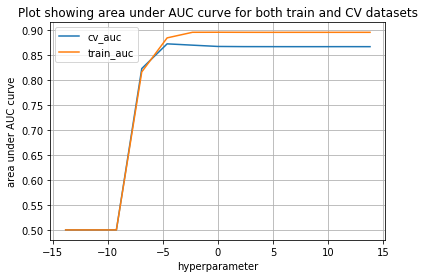

In [21]:
#plotting AUC score of Cross validation data and training data
plt.plot(log_c,cv_roc,label = 'cv_auc')
plt.plot(log_c,train_roc,label = 'train_auc')
plt.xlabel('hyperparameter')
plt.ylabel('area under AUC curve')
plt.title("Plot showing area under AUC curve for both train and CV datasets")
plt.grid()
plt.legend()
plt.show()

## Observation:
<pre>We can see from above plot that as C increases area under ROC curve increases and then after some value of C the area under ROC curve starts saturating.</pre>

In [22]:
#From above we found the best value of C = 0.01. Therefor we will now test our model on our test dataset.
lr = LogisticRegression(penalty = 'l1',C=0.01)
lr.fit(standardized_train,y_train)
pred = lr.predict(standardized_test)
print('For C = {0} the area under AUC curve is = {1}\n'.format(0.01,roc_auc_score(y_test, pred)))

For C = 0.01 the area under AUC curve is = 0.8656845797683996



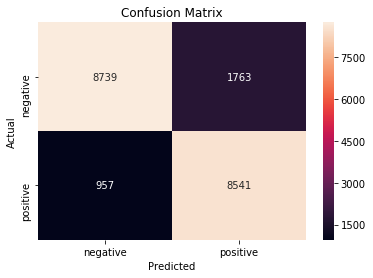

_____________________________________________________________________________________________________

For C = 0.01, the TPR = 89.92419456727733, TNR = 83.21272138640259, FPR = 16.787278613597408, FNR = 10.075805432722678


In [23]:
#plotting our confusion matrix
co_mt = confusion_matrix(y_test,pred)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(co_mt, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)
TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100# calculating TNR, TPR, FPR, FNR
FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
print('\nFor C = {0}, the TPR = {1}, TNR = {2}, FPR = {3}, FNR = {4}'.format(0.01,TPR,TNR,FPR,FNR))

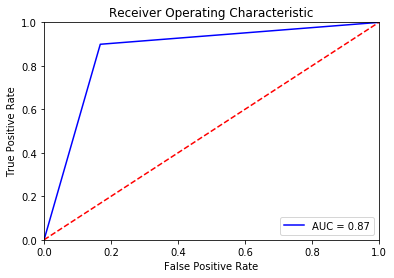

In [24]:
#plotting ROC curve for y_test
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)#roc_curve returns true positive rates and false positive rates for y-test
roc_auc = metrics.auc(fpr, tpr)#computes area under roc_curve using trapezoidal rule or in other words we can say using inte-
#-gration
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])#limiting values of x-axis between 0 and 1
plt.ylim([0, 1])#limiting values of y-axis between 0 and 1
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Observation:
<pre>We can see that area under above ROC curve is 87% and hence is better than a simple mean model.</pre>

#### [2.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW

In [25]:
w = lr.coef_#coef_ gives us our weight vector
size = w.size
zero = ((size-np.count_nonzero(w))/size)*100
print('%age sparsity on weight vector obtained using L1 regularization on BOW',zero)

%age sparsity on weight vector obtained using L1 regularization on BOW 54.489465153970826


### [2.1.2] Applying Logistic Regression with L2 regularization on BOW

In [26]:
#Here we are trying to find area under AUC score along with Confusion matrix for train dataset for various values of-
#- C using Logistic Regression
train_roc = []
C = [10**6,10**5,10**4,10**3,10**2,10,1,10**-1,10**-2,10**-3,10**-4,10**-5,10**-6]
for i in C:
    lr = LogisticRegression(penalty = 'l2',C=i)
    lr.fit(standardized_train,y_train)
    pred = lr.predict(standardized_train)
    train_roc.append(roc_auc_score(y_train, pred))#roc_auc_score calculates area under the roc curve 

In [27]:
#performing simple cross validation using Logistic Regression for various values of C. Our metrics are-
#- area under auc curve and Confusion matrix
cv_roc = []
C = [10**6,10**5,10**4,10**3,10**2,10,1,10**-1,10**-2,10**-3,10**-4,10**-5,10**-6]
for i in C:
    lr = LogisticRegression(penalty = 'l2',C=i)
    lr.fit(standardized_train,y_train)
    pred = lr.predict(standardized_cv)
    cv_roc.append(roc_auc_score(y_cv, pred))
    co_mt = confusion_matrix(y_cv,pred)
    TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100# calculating TNR, TPR, FPR, FNR
    FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
    TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
    FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100  
    print('\nFor C = {0}, the area under AUC curve is = {1}, the TPR = {2}, TNR = {3}, FPR = {4}, FNR = {5}'.format(i,roc_auc_score(y_cv, pred),TPR,TNR,FPR,FNR))


For C = 1000000, the area under AUC curve is = 0.8660809178743961, the TPR = 90.27173913043478, TNR = 82.94444444444444, FPR = 17.055555555555554, FNR = 9.728260869565217

For C = 100000, the area under AUC curve is = 0.8660809178743961, the TPR = 90.27173913043478, TNR = 82.94444444444444, FPR = 17.055555555555554, FNR = 9.728260869565217

For C = 10000, the area under AUC curve is = 0.8660809178743961, the TPR = 90.27173913043478, TNR = 82.94444444444444, FPR = 17.055555555555554, FNR = 9.728260869565217

For C = 1000, the area under AUC curve is = 0.8660809178743961, the TPR = 90.27173913043478, TNR = 82.94444444444444, FPR = 17.055555555555554, FNR = 9.728260869565217

For C = 100, the area under AUC curve is = 0.8660809178743961, the TPR = 90.27173913043478, TNR = 82.94444444444444, FPR = 17.055555555555554, FNR = 9.728260869565217

For C = 10, the area under AUC curve is = 0.8660809178743961, the TPR = 90.27173913043478, TNR = 82.94444444444444, FPR = 17.055555555555554, FNR = 9

## Observation:
<pre>As we can see from above that we are getting maximum value of AUC for C = 0.0001, therefore we will choose that value of C as our hyperparameter value.</pre>

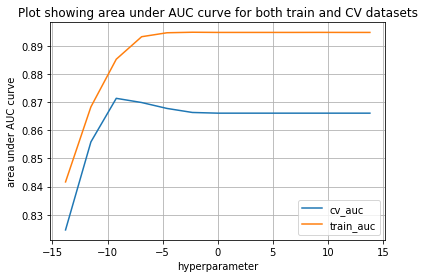

In [28]:
#plotting AUC score of Cross validation data and training data
plt.plot(log_c,cv_roc,label = 'cv_auc')
plt.plot(log_c,train_roc,label = 'train_auc')
plt.xlabel('hyperparameter')
plt.ylabel('area under AUC curve')
plt.title("Plot showing area under AUC curve for both train and CV datasets")
plt.grid()
plt.legend()
plt.show()

## Observation
<pre>We can see from above plot that as value of C increases our model is getting more and more overfitted. This is because the area under ROC curve for training dataset is increasing at the faster rate as compared to area under ROC curve for CV dataset. This means as C increases the performance of  model is increasing at faster rate on training dataset as compared to performance of same model on CV dataset and hence we are overfitting to training dataset as C increases.</pre>

In [29]:
#From above we found the best value of C = 0.0001. Therefor we will now test our model on our test dataset.
lr = LogisticRegression(penalty = 'l2',C=0.0001)
lr.fit(standardized_train,y_train)
pred = lr.predict(standardized_test)
print('For C = {0} the area under AUC curve is = {1}\n'.format(0.0001,roc_auc_score(y_test, pred)))

For C = 0.0001 the area under AUC curve is = 0.8633505779905593



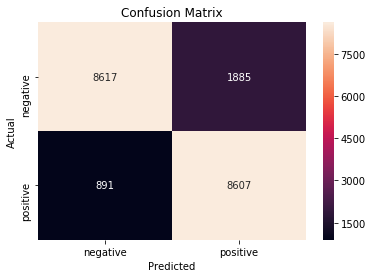

_____________________________________________________________________________________________________

For C = 0.0001, the TPR = 90.61907770056854, TNR = 82.05103789754332, FPR = 17.948962102456676, FNR = 9.38092229943146


In [30]:
#plotting our confusion matrix
co_mt = confusion_matrix(y_test,pred)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(co_mt, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)
TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100# calculating TNR, TPR, FPR, FNR
FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
print('\nFor C = {0}, the TPR = {1}, TNR = {2}, FPR = {3}, FNR = {4}'.format(0.0001,TPR,TNR,FPR,FNR))

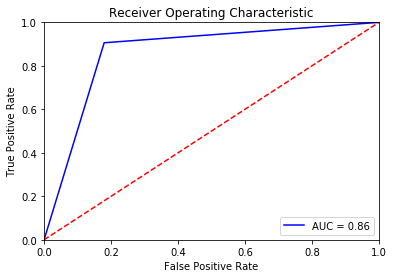

In [31]:
#plotting ROC curve for y_test
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)#roc_curve returns true positive rates and false positive rates for y-test
roc_auc = metrics.auc(fpr, tpr)#computes area under roc_curve using trapezoidal rule or in other words we can say using inte-
#-gration
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])#limiting values of x-axis between 0 and 1
plt.ylim([0, 1])#limiting values of y-axis between 0 and 1
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Observation:
<pre>We can see from above plot that our model is better than simple mean model because the area under ROC curve is greater than 50%.</pre>

In [32]:
w_1 = lr.coef_# we are getting here weights which we found using L2 regularizer on Logistic Regression 
w_1

array([[0.00717821, 0.02609403, 0.01672544, ..., 0.00685148, 0.01308704,
        0.01205477]])

In [33]:
w_1 = w_1+10**-6 #Adding 10^-6 to prevent division by zero when we will perform perturbation test later
w_1

array([[0.00717921, 0.02609503, 0.01672644, ..., 0.00685248, 0.01308804,
        0.01205577]])

#### [2.1.2.1] Performing pertubation test (multicollinearity check) on BOW

In [34]:
epsilon = 0.05

In [35]:
train_bow.data = train_bow.data + epsilon #adding pertubation to our bag of words representation of training dataset
train_bow_df = pd.DataFrame(train_bow.toarray(),columns = model.get_feature_names())# converting train_bow into dataframe
standardized_train = StandardScaler().fit_transform(train_bow_df)#Here we are standardizing train_bow_df dataframes

In [36]:
#Here we are trying to find area under AUC score along with Confusion matrix for train dataset for various values of-
#- C using Logistic Regression
train_roc = []
C = [10**6,10**5,10**4,10**3,10**2,10,1,10**-1,10**-2,10**-3,10**-4,10**-5,10**-6]
for i in C:
    lr = LogisticRegression(penalty = 'l2',C=i)
    lr.fit(standardized_train,y_train)
    pred = lr.predict(standardized_train)
    train_roc.append(roc_auc_score(y_train, pred))#roc_auc_score calculates area under the roc curve 

In [37]:
#performing simple cross validation using Logistic Regression for various values of C. Our metrics are-
#- area under auc curve and Confusion matrix
cv_roc = []
C = [10**6,10**5,10**4,10**3,10**2,10,1,10**-1,10**-2,10**-3,10**-4,10**-5,10**-6]
for i in C:
    lr = LogisticRegression(penalty = 'l2',C=i)
    lr.fit(standardized_train,y_train)
    pred = lr.predict(standardized_cv)
    cv_roc.append(roc_auc_score(y_cv, pred))
    co_mt = confusion_matrix(y_cv,pred)
    TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100# calculating TNR, TPR, FPR, FNR
    FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
    TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
    FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100  
    print('\nFor C = {0}, the area under AUC curve is = {1}, the TPR = {2}, TNR = {3}, FPR = {4}, FNR = {5}'.format(i,roc_auc_score(y_cv, pred),TPR,TNR,FPR,FNR))


For C = 1000000, the area under AUC curve is = 0.8663506441223834, the TPR = 90.26086956521739, TNR = 83.00925925925927, FPR = 16.99074074074074, FNR = 9.73913043478261

For C = 100000, the area under AUC curve is = 0.8663506441223834, the TPR = 90.26086956521739, TNR = 83.00925925925927, FPR = 16.99074074074074, FNR = 9.73913043478261

For C = 10000, the area under AUC curve is = 0.8663506441223834, the TPR = 90.26086956521739, TNR = 83.00925925925927, FPR = 16.99074074074074, FNR = 9.73913043478261

For C = 1000, the area under AUC curve is = 0.8663506441223834, the TPR = 90.26086956521739, TNR = 83.00925925925927, FPR = 16.99074074074074, FNR = 9.73913043478261

For C = 100, the area under AUC curve is = 0.8663506441223834, the TPR = 90.26086956521739, TNR = 83.00925925925927, FPR = 16.99074074074074, FNR = 9.73913043478261

For C = 10, the area under AUC curve is = 0.8663506441223834, the TPR = 90.26086956521739, TNR = 83.00925925925927, FPR = 16.99074074074074, FNR = 9.7391304347

## Observation:
<pre>As we can see from above that we are getting maximum value of AUC for C = 0.0001 , therefore we will choose that value of C as our hyperparameter value.</pre>

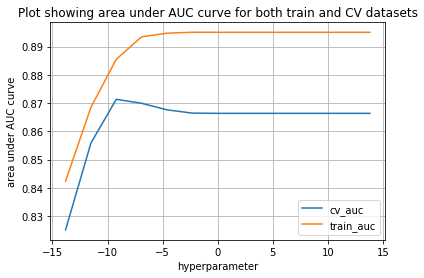

In [38]:
#plotting AUC score of Cross validation data and training data
plt.plot(log_c,cv_roc,label = 'cv_auc')
plt.plot(log_c,train_roc,label = 'train_auc')
plt.xlabel('hyperparameter')
plt.ylabel('area under AUC curve')
plt.title("Plot showing area under AUC curve for both train and CV datasets")
plt.grid()
plt.legend()
plt.show()

## Observation
<pre>We can see from above plot that as value of C increases our model is getting more and more overfitted. This is because the area under ROC curve for training dataset is increasing at the faster rate as compared to area under ROC curve for CV dataset. This means as C increases the performance of  model is increasing at faster rate on training dataset as compared to performance of same model on CV dataset and hence we are overfitting to training dataset as C increases.</pre>

In [39]:
#From above we found the best value of C = 0.0001. Therefor we will now test our model on our test dataset.
lr = LogisticRegression(penalty = 'l2',C=0.0001)
lr.fit(standardized_train,y_train)
pred = lr.predict(standardized_test)
print('For C = {0} the area under AUC curve is = {1}\n'.format(0.0001,roc_auc_score(y_test, pred)))

For C = 0.0001 the area under AUC curve is = 0.8635986932509401



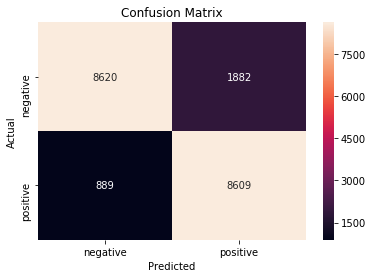

_____________________________________________________________________________________________________

For C = 0.0001, the TPR = 90.64013476521373, TNR = 82.07960388497429, FPR = 17.92039611502571, FNR = 9.35986523478627


In [40]:
#plotting our confusion matrix
co_mt = confusion_matrix(y_test,pred)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(co_mt, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)
TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100# calculating TNR, TPR, FPR, FNR
FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
print('\nFor C = {0}, the TPR = {1}, TNR = {2}, FPR = {3}, FNR = {4}'.format(0.0001,TPR,TNR,FPR,FNR))

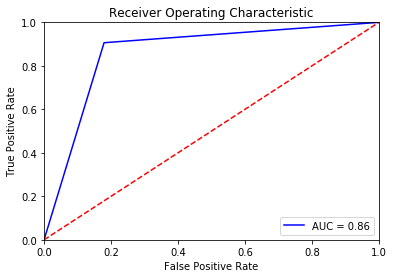

In [41]:
#plotting ROC curve for y_test
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)#roc_curve returns true positive rates and false positive rates for y-test
roc_auc = metrics.auc(fpr, tpr)#computes area under roc_curve using trapezoidal rule or in other words we can say using inte-
#-gration
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])#limiting values of x-axis between 0 and 1
plt.ylim([0, 1])#limiting values of y-axis between 0 and 1
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [42]:
w_2 = lr.coef_
w_2 = w_2+10**-6 #Adding 10^-6 to prevent division by zero when we will calculate perturbation 

In [43]:
#calculating %age change in features due to perturbation
delta_w = (abs(w_1[0] - w_2[0])/w_1[0]) * 100
# save the model to disk
filename = 'delta.pkl'
pickle.dump(delta_w, open(filename, 'wb'))


In [44]:
def percentile(low,high,step,array):
    """function to calculate percentiles.
    Input: low,high,step,array. 'array' is the array whose percentiles we want to calculate. 'low is the lowest percentile
           we want to calculate and high is the highest percentile value we want to calculate. 'step' defines the amount of
           step size."""
    for i in np.arange(low,high,step):
        print('The {}th percentile is: {}'.format(i,np.percentile(array,i)))
percentile(0,110,10,delta_w)

The 0th percentile is: -14973.208860183977
The 10th percentile is: -1.9602866608834064
The 20th percentile is: -0.8670759841623339
The 30th percentile is: -0.4209651026780417
The 40th percentile is: -0.19061346386146322
The 50th percentile is: -0.017946037538026687
The 60th percentile is: 0.1819333626081236
The 70th percentile is: 0.47627376519659154
The 80th percentile is: 0.9337611374099434
The 90th percentile is: 2.14056622332176
The 100th percentile is: 851.1952169274574


<pre>From above we can see that there is a sudden rise in percentage weight change vector from -14973.208(which is 0th percentile value) to  -1.96 (which is 10th percentile value) and 2.14(which is 90th percentile value) to 851.195(which is 100th percentile value). Therefore we will further calculate percentile values between 90th to 100th percentile to see that where is actually this sharp change in percentage weight change vector happening.</pre>

In [45]:
percentile(90,101,1,delta_w) #Here we are calculating 90,91,92,----,100 percentile values of delta_w

The 90th percentile is: 2.14056622332176
The 91th percentile is: 2.357472686282099
The 92th percentile is: 2.6180826348570214
The 93th percentile is: 3.1034137118704264
The 94th percentile is: 3.6294814269895594
The 95th percentile is: 4.512811826711675
The 96th percentile is: 5.6450410413386125
The 97th percentile is: 7.398528049723717
The 98th percentile is: 10.983266951804062
The 99th percentile is: 23.431335609455534
The 100th percentile is: 851.1952169274574


<pre>From above we can see that there is a sudden rise in percentage weight change vector from 10.98(which is 99th percentile value) to 23.43(which is 99th percentile value) to 851.19 (which is 100th percentile value).Therefore we will further calculate percentile values between 98th to 100th percentile to see that where is actually this sharp change in percentage weight change vector happening. </pre>

In [46]:
percentile(98,100.1,0.1,delta_w)# Calculating 98,98.1,98.2,......,99,99.1,99.2,......100 percentile values

The 98.0th percentile is: 10.983266951804062
The 98.1th percentile is: 11.589274422515766
The 98.19999999999999th percentile is: 12.713424648819164
The 98.29999999999998th percentile is: 13.366505127135554
The 98.39999999999998th percentile is: 13.985958343653255
The 98.49999999999997th percentile is: 15.2646744280421
The 98.59999999999997th percentile is: 16.532286298893045
The 98.69999999999996th percentile is: 17.8844180826798
The 98.79999999999995th percentile is: 19.27229376609144
The 98.89999999999995th percentile is: 20.75615509324452
The 98.99999999999994th percentile is: 23.431335609454212
The 99.09999999999994th percentile is: 25.272508918905285
The 99.19999999999993th percentile is: 27.63163001173355
The 99.29999999999993th percentile is: 30.376806650086962
The 99.39999999999992th percentile is: 38.501102789538805
The 99.49999999999991th percentile is: 44.710284671397545
The 99.59999999999991th percentile is: 50.890862813452046
The 99.6999999999999th percentile is: 60.380138

<pre>From above we can see that there is a sudden rise in percentage weight change vector from 66.25(which is 99.8 th percentile value) to 119.311(which is 99.9th percentile value).Therefore our threshold value = 66.25</pre>

In [47]:
delta = pd.DataFrame()#Creating an empty dataframe
delta['features'] = model.get_feature_names()#putting our feature names in dataframe
delta['delta'] = delta_w# putting percentage weight vector change vector in dataframe

In [48]:
delta.sort_values('delta',inplace = True)#sorting the dataframe in accordance with 'delta' column

In [49]:
delta[delta['delta']>66.25]# Displaying feature names with maximum percentage weight vector change due to pertubation

,features,delta
723,detail,66.396305
2466,snow,82.402443
2208,repeat,91.785694
616,crash,121.835846
1143,glass,276.199640
849,effici,549.395275
1303,hodgson,851.195217


### [2.1.3] Feature Importance on BOW

#### [2.1.3.1] Top 10 important features of positive and negative class

In [50]:
#function to get important features
def most_important_features(model, clf, n=10):
    feature_names = model.get_feature_names()#Here I am getting feature names stored in my model
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names)) #Here I am trying to create a sorted list containing tuples of-
    #-the form (prob,feature_name)
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])#here I am selecting top n important words-
    #- corresponding to positive class and bottom n words corresponding to negative class
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
most_important_features(model,lr)
#Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Positive						Negative
________________________________________________________________________________________________
	-0.1645	disappoint     				0.1977	great          
	-0.0972	worst          				0.1494	love           
	-0.0918	aw             				0.1398	best           
	-0.0897	terribl        				0.1287	delici         
	-0.0861	bad            				0.1009	perfect        
	-0.0841	horribl        				0.0978	excel          
	-0.0840	wast           				0.0941	good           
	-0.0837	money          				0.0859	favorit        
	-0.0815	return         				0.0796	easi           
	-0.0775	tast           				0.0762	nice           


# 3. TF-IDF

In [51]:
#tf-idf on train dataset
vectorizer = TfidfVectorizer(min_df = 50)#defining our tf-idf model and considering only those words which occur more than 50-
#times in our document
model = vectorizer.fit(x_train)#Here we are learning the internal parameters (i.e vocabulary) of our train dataset-
#- (i.e. review text)
print(vectorizer.vocabulary_) #visualizing the parameters learnt (i.e vocabulary)

{'yucki': 3075, 'chai': 420, 'gotta': 1168, 'girlfriend': 1139, 'pleas': 2004, 'tire': 2779, 'buffalo': 331, 'artifici': 137, 'fight': 1002, 'mixer': 1726, 'novemb': 1821, 'mold': 1736, 'maltodextrin': 1629, 'frustrat': 1096, 'compet': 534, 'cost': 595, 'sort': 2496, 'instant': 1402, 'fan': 968, 'sport': 2532, 'happen': 1238, 'ala': 60, 'went': 2985, 'thrill': 2761, 'extens': 947, 'hous': 1325, 'pistachio': 1991, 'shipment': 2391, 'disgust': 765, 'began': 222, 'switch': 2670, 'volum': 2944, 'chew': 445, 'exot': 932, 'wax': 2968, 'certain': 418, 'specifi': 2515, 'facil': 954, 'roaster': 2255, 'although': 79, 'folk': 1050, 'open': 1869, 'butter': 348, 'fashion': 974, 'tap': 2693, 'men': 1682, 'holiday': 1307, 'bake': 181, 'wide': 3007, 'slight': 2439, 'cloy': 497, 'ziplock': 3084, 'barbecu': 193, 'theyll': 2742, 'merrick': 1686, 'airtight': 57, 'primarili': 2063, 'dozen': 798, 'earth': 833, 'soybean': 2504, 'mile': 1702, 'see': 2346, 'mayo': 1662, 'sam': 2298, 'lentil': 1547, 'hunger': 1

In [52]:
train_tfidf = model.transform(x_train)#here we are using the internal parameters we learnt above to convert our reviews 
#- in x_train into matrices
cv_tfidf = model.transform(x_cv)#here we are using the internal parameters we learnt above to convert our reviews in 
#- x_cv into matrices
test_tfidf = model.transform(x_test)#here we are using the internal parameters we learnt above to convert our reviews in 
#- x_test into matrices

In [53]:
#here we are first creating a dataframes out of train_tfidf, cv_tfidf and test_tfidf
train_tfidf_df = pd.DataFrame(train_tfidf.toarray(),columns = model.get_feature_names())
cv_tfidf_df = pd.DataFrame(cv_tfidf.toarray(),columns = model.get_feature_names())
test_tfidf_df = pd.DataFrame(test_tfidf.toarray(),columns = model.get_feature_names())

In [54]:
#here we are creating standardized train, standardized cv and standardized test matrices
standardized_train_tfidf = StandardScaler().fit_transform(train_tfidf_df)
standardized_cv_tfidf = StandardScaler().fit_transform(cv_tfidf_df)
standardized_test_tfidf = StandardScaler().fit_transform(test_tfidf_df)

In [55]:
standardized_train_tfidf.shape

(60000, 3085)

### [3.1] Applying Logistic Regression with L1 regularization on TFIDF

In [56]:
#Here we are trying to find area under AUC score along with Confusion matrix for train dataset for various values of-
#- C using Logistic Regression
train_roc = []
C = [10**6,10**5,10**4,10**3,10**2,10,1,10**-1,10**-2,10**-3,10**-4,10**-5,10**-6]
for i in C:
    lr = LogisticRegression(penalty = 'l1',C=i)
    lr.fit(standardized_train_tfidf,y_train)
    pred = lr.predict(standardized_train_tfidf)
    train_roc.append(roc_auc_score(y_train, pred))#roc_auc_score calculates area under the roc curve 

In [57]:
#performing simple cross validation using Logistic Regression for various values of C. Our metrics are-
#- area under auc curve and Confusion matrix
cv_roc = []
C = [10**6,10**5,10**4,10**3,10**2,10,1,10**-1,10**-2,10**-3,10**-4,10**-5,10**-6]
for i in C:
    lr = LogisticRegression(penalty = 'l1',C=i)
    lr.fit(standardized_train_tfidf,y_train)
    pred = lr.predict(standardized_cv_tfidf)
    cv_roc.append(roc_auc_score(y_cv, pred))
    co_mt = confusion_matrix(y_cv,pred)
    TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100# calculating TNR, TPR, FPR, FNR
    FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
    TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
    FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100  
    print('\nFor C = {0}, the area under AUC curve is = {1}, the TPR = {2}, TNR = {3}, FPR = {4}, FNR = {5}'.format(i,roc_auc_score(y_cv, pred),TPR,TNR,FPR,FNR))


For C = 1000000, the area under AUC curve is = 0.8705454911433173, the TPR = 90.17391304347827, TNR = 83.93518518518519, FPR = 16.064814814814817, FNR = 9.826086956521738

For C = 100000, the area under AUC curve is = 0.8705917874396135, the TPR = 90.17391304347827, TNR = 83.94444444444444, FPR = 16.055555555555557, FNR = 9.826086956521738

For C = 10000, the area under AUC curve is = 0.8705917874396135, the TPR = 90.17391304347827, TNR = 83.94444444444444, FPR = 16.055555555555557, FNR = 9.826086956521738

For C = 1000, the area under AUC curve is = 0.8705917874396135, the TPR = 90.17391304347827, TNR = 83.94444444444444, FPR = 16.055555555555557, FNR = 9.826086956521738

For C = 100, the area under AUC curve is = 0.8705454911433173, the TPR = 90.17391304347827, TNR = 83.93518518518519, FPR = 16.064814814814817, FNR = 9.826086956521738

For C = 10, the area under AUC curve is = 0.8706380837359097, the TPR = 90.17391304347827, TNR = 83.95370370370371, FPR = 16.046296296296298, FNR = 9

## Observation:
<pre>As we can see from above that we are getting maximum value of AUC for C = 0.01 , therefore we will choose that value of C as our hyperparameter value.</pre>

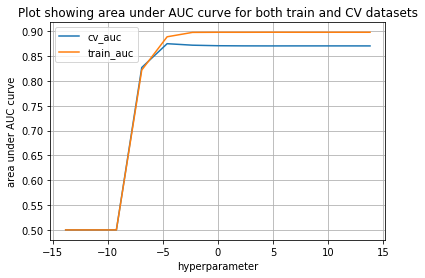

In [58]:
#plotting AUC score of Cross validation data and training data
plt.plot(log_c,cv_roc,label = 'cv_auc')
plt.plot(log_c,train_roc,label = 'train_auc')
plt.xlabel('hyperparameter')
plt.ylabel('area under AUC curve')
plt.title("Plot showing area under AUC curve for both train and CV datasets")
plt.grid()
plt.legend()
plt.show()

## Observation
<pre>We can see from above plot that as value of C increases our model is getting more and more overfitted. This is because the area under ROC curve for training dataset is increasing at the faster rate for log(C) > (-5) as compared to area under ROC curve for CV dataset. This means as C increases the performance of  model is increasing at faster rate on training dataset as compared to performance of same model on CV dataset and hence we are overfitting to training dataset as C increases.</pre>

In [59]:
#From above we found the best value of C = 0.01. Therefor we will now test our model on our test dataset.
lr = LogisticRegression(penalty = 'l1',C=0.01)
lr.fit(standardized_train_tfidf,y_train)
pred = lr.predict(standardized_test_tfidf)
print('For C = {0} the area under AUC curve is = {1}\n'.format(0.01,roc_auc_score(y_test, pred)))

For C = 0.01 the area under AUC curve is = 0.8712936047356781



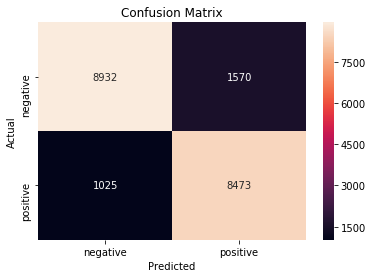

_____________________________________________________________________________________________________

For C = 0.01, the TPR = 89.2082543693409, TNR = 85.05046657779471, FPR = 14.949533422205294, FNR = 10.791745630659086


In [60]:
#plotting our confusion matrix
co_mt = confusion_matrix(y_test,pred)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(co_mt, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)
TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100# calculating TNR, TPR, FPR, FNR
FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
print('\nFor C = {0}, the TPR = {1}, TNR = {2}, FPR = {3}, FNR = {4}'.format(0.01,TPR,TNR,FPR,FNR))

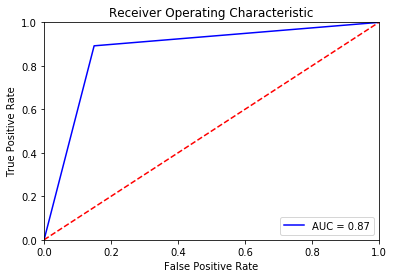

In [61]:
#plotting ROC curve for y_test
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)#roc_curve returns true positive rates and false positive rates for y-test
roc_auc = metrics.auc(fpr, tpr)#computes area under roc_curve using trapezoidal rule or in other words we can say using inte-
#-gration
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])#limiting values of x-axis between 0 and 1
plt.ylim([0, 1])#limiting values of y-axis between 0 and 1
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Observation:
<pre>From above plot we can see that our model is better than simple mean model as area under ROC curve > 50%</pre>

### [3.2] Applying Logistic Regression with L2 regularization on TFIDF

In [62]:
#Here we are trying to find area under AUC score along with Confusion matrix for train dataset for various values of-
#- C using Logistic Regression
train_roc = []
C = [10**6,10**5,10**4,10**3,10**2,10,1,10**-1,10**-2,10**-3,10**-4,10**-5,10**-6]
for i in C:
    lr = LogisticRegression(penalty = 'l2',C=i)
    lr.fit(standardized_train_tfidf,y_train)
    pred = lr.predict(standardized_train_tfidf)
    train_roc.append(roc_auc_score(y_train, pred))#roc_auc_score calculates area under the roc curve 

In [63]:
#performing simple cross validation using Logistic Regression for various values of C. Our metrics are-
#- area under auc curve and Confusion matrix
cv_roc = []
C = [10**6,10**5,10**4,10**3,10**2,10,1,10**-1,10**-2,10**-3,10**-4,10**-5,10**-6]
for i in C:
    lr = LogisticRegression(penalty = 'l2',C=i)
    lr.fit(standardized_train_tfidf,y_train)
    pred = lr.predict(standardized_cv_tfidf)
    cv_roc.append(roc_auc_score(y_cv, pred))
    co_mt = confusion_matrix(y_cv,pred)
    TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100# calculating TNR, TPR, FPR, FNR
    FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
    TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
    FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100  
    print('\nFor C = {0}, the area under AUC curve is = {1}, the TPR = {2}, TNR = {3}, FPR = {4}, FNR = {5}'.format(i,roc_auc_score(y_cv, pred),TPR,TNR,FPR,FNR))


For C = 1000000, the area under AUC curve is = 0.870499194847021, the TPR = 90.17391304347827, TNR = 83.92592592592592, FPR = 16.074074074074073, FNR = 9.826086956521738

For C = 100000, the area under AUC curve is = 0.870499194847021, the TPR = 90.17391304347827, TNR = 83.92592592592592, FPR = 16.074074074074073, FNR = 9.826086956521738

For C = 10000, the area under AUC curve is = 0.870499194847021, the TPR = 90.17391304347827, TNR = 83.92592592592592, FPR = 16.074074074074073, FNR = 9.826086956521738

For C = 1000, the area under AUC curve is = 0.870499194847021, the TPR = 90.17391304347827, TNR = 83.92592592592592, FPR = 16.074074074074073, FNR = 9.826086956521738

For C = 100, the area under AUC curve is = 0.870499194847021, the TPR = 90.17391304347827, TNR = 83.92592592592592, FPR = 16.074074074074073, FNR = 9.826086956521738

For C = 10, the area under AUC curve is = 0.870499194847021, the TPR = 90.17391304347827, TNR = 83.92592592592592, FPR = 16.074074074074073, FNR = 9.82608

## Observation:
<pre>As we can see from above that we are getting maximum value of AUC for C = 0.001, therefore we will choose that value of C as our hyperparameter value.</pre>

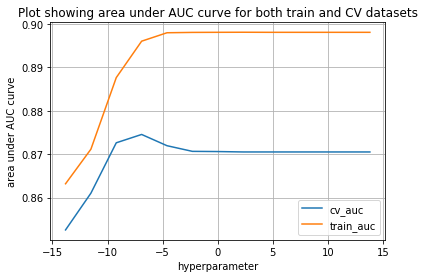

In [64]:
#plotting AUC score of Cross validation data and training data
plt.plot(log_c,cv_roc,label = 'cv_auc')
plt.plot(log_c,train_roc,label = 'train_auc')
plt.xlabel('hyperparameter')
plt.ylabel('area under AUC curve')
plt.title("Plot showing area under AUC curve for both train and CV datasets")
plt.grid()
plt.legend()
plt.show()

## Observation
<pre>We can see from above plot that as value of C increases our model is getting more and more overfitted. This is because the area under ROC curve for training dataset is increasing at the faster rate as compared to area under ROC curve for CV dataset. This means as C increases the performance of  model is increasing at faster rate on training dataset as compared to performance of same model on CV dataset and hence we are overfitting to training dataset as C increases.</pre>

In [65]:
#From above we found the best value of C = 0.001. Therefor we will now test our model on our test dataset.
lr = LogisticRegression(penalty = 'l2',C=0.001)
lr.fit(standardized_train_tfidf,y_train)
pred = lr.predict(standardized_test_tfidf)
print('For C = {0} the area under AUC curve is = {1}\n'.format(0.001,roc_auc_score(y_test, pred)))

For C = 0.001 the area under AUC curve is = 0.8673992508080061



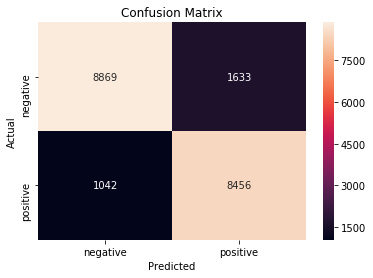

_____________________________________________________________________________________________________

For C = 0.001, the TPR = 89.02926931985681, TNR = 84.45058084174443, FPR = 15.54941915825557, FNR = 10.970730680143188


In [66]:
#plotting our confusion matrix
co_mt = confusion_matrix(y_test,pred)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(co_mt, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)
TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100# calculating TNR, TPR, FPR, FNR
FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
print('\nFor C = {0}, the TPR = {1}, TNR = {2}, FPR = {3}, FNR = {4}'.format(0.001,TPR,TNR,FPR,FNR))

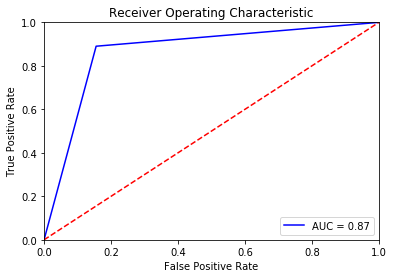

In [67]:
#plotting ROC curve for y_test
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)#roc_curve returns true positive rates and false positive rates for y-test
roc_auc = metrics.auc(fpr, tpr)#computes area under roc_curve using trapezoidal rule or in other words we can say using inte-
#-gration
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])#limiting values of x-axis between 0 and 1
plt.ylim([0, 1])#limiting values of y-axis between 0 and 1
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Observation:
<pre>We can see from above plot that our model is better than simple mean model as area under curve is greater than 50%</pre>

### [3.2.1] Feature Importance on TFIDF

#### [3.2.1.1] Top 10 important features of positive class and negative class

In [68]:
#function to get important features
def most_important_features(model, clf, n=10):
    feature_names = model.get_feature_names()#Here I am getting feature names stored in my model
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names)) #Here I am trying to create a sorted list containing tuples of-
    #-the form (prob,feature_name)
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])#here I am selecting top n important words-
    #- corresponding to positive class and bottom n words corresponding to negative class
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [69]:
most_important_features(model,lr)

			Positive						Negative
________________________________________________________________________________________________
	-0.3270	disappoint     				0.4493	great          
	-0.2350	worst          				0.3534	love           
	-0.2095	aw             				0.3289	best           
	-0.1981	terribl        				0.3112	delici         
	-0.1773	horribl        				0.2449	good           
	-0.1731	return         				0.2328	perfect        
	-0.1565	stale          				0.2271	excel          
	-0.1543	wast           				0.1728	favorit        
	-0.1511	bland          				0.1681	nice           
	-0.1488	threw          				0.1513	find           


# 4. Word2Vec

In [70]:
#splitting each of my reviews in x_train into list of, list of stemmed words in each of our stemmed reviews in x_train
list_of_sent = []
for sent in x_train.values:
    list_of_sent.append(sent.split())

In [71]:
#splitting each of my reviews in x_cv into list of, list of stemmed words in each of our stemmed reviews in x_cv
list_of_sent_cv = []
for sent in x_cv.values:
    list_of_sent_cv.append(sent.split())

In [72]:
#splitting each of my reviews in x_test into list of, list of stemmed words in each of our stemmed reviews in x_test
list_of_sent_test = []
for sent in x_test.values:
    list_of_sent_test.append(sent.split())

In [73]:
w2v_model = Word2Vec(list_of_sent,min_count = 5,size = 50,workers = 4) #Here I am creating word2vec representation of each of-
#- the words in my 'list_of_sent' list i.e I am creating w2v representation of words in reviews of x_train, where we-
#- are creating word2vec vectors for words in 'list_of_sent' list which-
#- occur >=5 times in the list. The number of dimensions of our word2ec vectors = 50 and number of cores which will carry-
#- on the job parallely = 4
print(w2v_model) #returns an iterator
#to see which words exist in our w2v-model
w2v_words = list(w2v_model.wv.vocab)#Here we are creating list of words, which are keys in dictionary 'w2v_model.wv.vocab'.
print(w2v_words)

Word2Vec(vocab=10422, size=50, alpha=0.025)
['zinc', 'thrift', 'shaken', 'velcro', 'wave', 'sound', 'coffeem', 'topic', 'dentastix', 'hanker', 'oyster', 'milk', 'let', 'puriti', 'teff', 'sooo', 'tai', 'goodby', 'seattl', 'shelti', 'nothin', 'inherit', 'redirect', 'renew', 'dandruff', 'sport', 'night', 'ths', 'homeopath', 'market', 'ashtray', 'mirin', 'tablespoon', 'tyler', 'yucki', 'hempse', 'usag', 'chai', 'massag', 'expel', 'prevail', 'carnat', 'cider', 'darkest', 'recommand', 'teen', 'later', 'sucr', 'spark', 'brainer', 'porous', 'poor', 'defeat', 'madelein', 'buddi', 'might', 'faith', 'reminer', 'specul', 'pinki', 'simpl', 'gotta', 'picki', 'girlfriend', 'pleas', 'muddl', 'nathan', 'jackpot', 'collaps', 'tire', 'buffalo', 'xlr', 'artifici', 'famous', 'michel', 'roomat', 'persian', 'fight', 'ad', 'potenti', 'potti', 'initi', 'biotin', 'labor', 'dumpl', 'hope', 'mandhel', 'societi', 'sofa', 'chondroitin', 'arabia', 'creol', 'garag', 'temper', 'injur', 'silver', 'whisk', 'liquid', 'co

## 4.1 Average Word2Vec

In [74]:
#average word2vec for each review in x_train
sent_vectors = []
for sent in tqdm(list_of_sent): #tqdm displays a progress bar. The progress bar tells us the rate at which-
    #-the looping operation is taking place
    sent_vec = np.zeros(50)# here we are creating numpy array of 50 zeros
    cnt_words = 0; #this variable will be used to count the number of words in each element (which is a list) of 'list_of_sent'
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]#here we are storing the word2vec representation of each word in sent-
            #- which is in 'w2v_words' list
            sent_vec += vec #here we are adding all the w2v vectors for each word in a review(or sent)
            cnt_words +=1
    if cnt_words!=0:
        sent_vec/=cnt_words #here we are calculating average w2v for each review(or sent) in x_train
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 60000/60000 [06:55<00:00, 141.33it/s]

60000
50


In [75]:
#average word2vec for each review in x_cv
sent_vectors_cv = []
for sent in tqdm(list_of_sent_cv): #tqdm displays a progress bar. The progress bar tells us the rate at which-
    #-the looping operation is taking place
    sent_vec = np.zeros(50)# here we are creating numpy array of 50 zeros
    cnt_words = 0; #this variable will be used to count the number of words in each element (which is a list) of 'list_of_sent_cv'
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]#here we are storing the word2vec representation of each word in sent-
            #- which is in 'w2v_words' list
            sent_vec += vec #here we are adding all the w2v vectors for each word in a review(or sent)
            cnt_words +=1
    if cnt_words!=0:
        sent_vec/=cnt_words #here we are calculating average w2v for each review(or sent) in x_cv
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

100%|██████████| 20000/20000 [02:20<00:00, 142.12it/s]

20000
50


In [76]:
#average word2vec for each review in x_test
sent_vectors_test = []
for sent in tqdm(list_of_sent_test): #tqdm displays a progress bar. The progress bar tells us the rate at which-
    #-the looping operation is taking place
    sent_vec = np.zeros(50)# here we are creating numpy array of 50 zeros
    cnt_words = 0; #this variable will be used to count the number of words in each element (which is a list) of 'list_of_sent_test'
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]#here we are storing the word2vec representation of each word in sent-
            #- which is in 'w2v_words' list
            sent_vec += vec #here we are adding all the w2v vectors for each word in a review(or sent)
            cnt_words +=1
    if cnt_words!=0:
        sent_vec/=cnt_words #here we are calculating average w2v for each review(or sent) in x_test
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|██████████| 20000/20000 [02:20<00:00, 141.97it/s]

20000
50


In [77]:
#here we are first creating a dataframe out of sent_vectors, sent_vectors_cv, sent_vectors_test
tfidf_w2v_tr = pd.DataFrame(sent_vectors)
tfidf_w2v_cv = pd.DataFrame(sent_vectors_cv)
tfidf_w2v_te = pd.DataFrame(sent_vectors_test)

In [78]:
#here we are standardizing the train, cv and test dataframes created above
standardized_train = StandardScaler().fit_transform(tfidf_w2v_tr)
standardized_cv = StandardScaler().fit_transform(tfidf_w2v_cv)
standardized_test = StandardScaler().fit_transform(tfidf_w2v_te)

In [79]:
standardized_train.shape

(60000, 50)

## [4.1.1] Logistic Regression on AVG W2V

### [4.1.1.1] Applying Logistic Regression with L1 regularization on AVG W2V

In [80]:
#Here we are trying to find area under AUC score along with Confusion matrix for train dataset for various values of-
#-C using Logistic Regression
train_roc = []
C = [10**6,10**5,10**4,10**3,10**2,10,1,10**-1,10**-2,10**-3,10**-4,10**-5,10**-6]
for i in C:
    lr = LogisticRegression(penalty = 'l1',C=i)
    lr.fit(standardized_train,y_train)
    pred = lr.predict(standardized_train)
    train_roc.append(roc_auc_score(y_train, pred))#roc_auc_score calculates area under the roc curve 

In [81]:
#performing simple cross validation using Logistic Regression for various values of C. Our metrics are-
#- area under auc curve and Confusion matrix
cv_roc = []
C = [10**6,10**5,10**4,10**3,10**2,10,1,10**-1,10**-2,10**-3,10**-4,10**-5,10**-6]
for i in C:
    lr = LogisticRegression(penalty = 'l1',C=i)
    lr.fit(standardized_train,y_train)
    pred = lr.predict(standardized_cv)
    cv_roc.append(roc_auc_score(y_cv, pred))
    co_mt = confusion_matrix(y_cv,pred)
    TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100# calculating TNR, TPR, FPR, FNR
    FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
    TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
    FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100  
    print('\nFor C = {0}, the area under AUC curve is = {1}, the TPR = {2}, TNR = {3}, FPR = {4}, FNR = {5}'.format(i,roc_auc_score(y_cv, pred),TPR,TNR,FPR,FNR))


For C = 1000000, the area under AUC curve is = 0.8350966183574879, the TPR = 87.3804347826087, TNR = 79.63888888888889, FPR = 20.36111111111111, FNR = 12.619565217391305

For C = 100000, the area under AUC curve is = 0.8349416264090177, the TPR = 87.3586956521739, TNR = 79.62962962962963, FPR = 20.37037037037037, FNR = 12.641304347826088

For C = 10000, the area under AUC curve is = 0.8350966183574879, the TPR = 87.3804347826087, TNR = 79.63888888888889, FPR = 20.36111111111111, FNR = 12.619565217391305

For C = 1000, the area under AUC curve is = 0.8348490338164251, the TPR = 87.3586956521739, TNR = 79.61111111111111, FPR = 20.38888888888889, FNR = 12.641304347826088

For C = 100, the area under AUC curve is = 0.8348490338164251, the TPR = 87.3586956521739, TNR = 79.61111111111111, FPR = 20.38888888888889, FNR = 12.641304347826088

For C = 10, the area under AUC curve is = 0.8348490338164251, the TPR = 87.3586956521739, TNR = 79.61111111111111, FPR = 20.38888888888889, FNR = 12.64130

## Observation:
<pre>As we can see from above that we are getting maximum value of AUC for C = 0.1, therefore we will choose that value of C as our hyperparameter value.</pre>

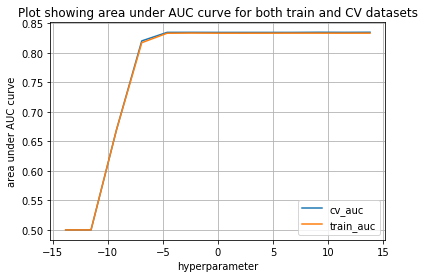

In [82]:
#plotting AUC score of Cross validation data and training data
plt.plot(log_c,cv_roc,label = 'cv_auc')
plt.plot(log_c,train_roc,label = 'train_auc')
plt.xlabel('hyperparameter')
plt.ylabel('area under AUC curve')
plt.title("Plot showing area under AUC curve for both train and CV datasets")
plt.grid()
plt.legend()
plt.show()

## Observation
<pre>We can see from above plot that as value of C increases our model is getting more and more better because as C is increasing our area under ROC curve is increasing at the same rate for both training dataset and CV dataset.</pre>

In [83]:
#From above we found the best value of C = 0.1. Therefor we will now test our model on our test dataset.
lr = LogisticRegression(penalty = 'l1',C=0.1)
lr.fit(standardized_train,y_train)
pred = lr.predict(standardized_test)
print('For C = {0} the area under AUC curve is = {1}\n'.format(0.1,roc_auc_score(y_test, pred)))

For C = 0.1 the area under AUC curve is = 0.8326658312012605



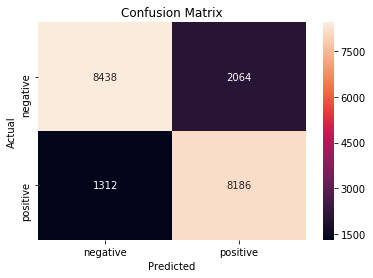

_____________________________________________________________________________________________________

For C = 0.1, the TPR = 86.18656559275637, TNR = 80.34660064749572, FPR = 19.653399352504287, FNR = 13.81343440724363


In [84]:
#plotting our confusion matrix
co_mt = confusion_matrix(y_test,pred)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(co_mt, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)
TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100# calculating TNR, TPR, FPR, FNR
FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
print('\nFor C = {0}, the TPR = {1}, TNR = {2}, FPR = {3}, FNR = {4}'.format(0.1,TPR,TNR,FPR,FNR))

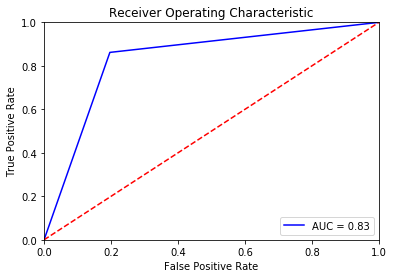

In [85]:
#plotting ROC curve for y_test
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)#roc_curve returns true positive rates and false positive rates for y-test
roc_auc = metrics.auc(fpr, tpr)#computes area under roc_curve using trapezoidal rule or in other words we can say using inte-
#-gration
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])#limiting values of x-axis between 0 and 1
plt.ylim([0, 1])#limiting values of y-axis between 0 and 1
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Observation:
<pre>As area under ROC curve > 50% therefore our model is better than Simple mean model.</pre>

### [4.1.1.2] Applying Logistic Regression with L2 regularization on AVG W2V

In [87]:
#Here we are trying to find area under AUC score along with Confusion matrix for train dataset for various values of-
#- C using Logistic Regression
train_roc = []
C = [10**6,10**5,10**4,10**3,10**2,10,1,10**-1,10**-2,10**-3,10**-4,10**-5,10**-6]
for i in C:
    lr = LogisticRegression(penalty = 'l2',C=i)
    lr.fit(standardized_train,y_train)
    pred = lr.predict(standardized_train)
    train_roc.append(roc_auc_score(y_train, pred))#roc_auc_score calculates area under the roc curve 

In [88]:
#performing simple cross validation using Logistic regression for various values of C. Our metrics are-
#- area under auc curve and Confusion matrix
cv_roc = []
C = [10**6,10**5,10**4,10**3,10**2,10,1,10**-1,10**-2,10**-3,10**-4,10**-5,10**-6]
for i in C:
    lr = LogisticRegression(penalty = 'l2',C=i)
    lr.fit(standardized_train,y_train)
    pred = lr.predict(standardized_cv)
    cv_roc.append(roc_auc_score(y_cv, pred))
    co_mt = confusion_matrix(y_cv,pred)
    TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100# calculating TNR, TPR, FPR, FNR
    FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
    TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
    FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100  
    print('\nFor C = {0}, the area under AUC curve is = {1}, the TPR = {2}, TNR = {3}, FPR = {4}, FNR = {5}'.format(i,roc_auc_score(y_cv, pred),TPR,TNR,FPR,FNR))


For C = 1000000, the area under AUC curve is = 0.8349416264090177, the TPR = 87.3586956521739, TNR = 79.62962962962963, FPR = 20.37037037037037, FNR = 12.641304347826088

For C = 100000, the area under AUC curve is = 0.8349416264090177, the TPR = 87.3586956521739, TNR = 79.62962962962963, FPR = 20.37037037037037, FNR = 12.641304347826088

For C = 10000, the area under AUC curve is = 0.8349416264090177, the TPR = 87.3586956521739, TNR = 79.62962962962963, FPR = 20.37037037037037, FNR = 12.641304347826088

For C = 1000, the area under AUC curve is = 0.8349416264090177, the TPR = 87.3586956521739, TNR = 79.62962962962963, FPR = 20.37037037037037, FNR = 12.641304347826088

For C = 100, the area under AUC curve is = 0.8349416264090177, the TPR = 87.3586956521739, TNR = 79.62962962962963, FPR = 20.37037037037037, FNR = 12.641304347826088

For C = 10, the area under AUC curve is = 0.8349416264090177, the TPR = 87.3586956521739, TNR = 79.62962962962963, FPR = 20.37037037037037, FNR = 12.64130

## Observation:
<pre>As we can see from above that we are getting maximum value of AUC for C = 0.01, therefore we will choose that value of C as our hyperparameter value.</pre>

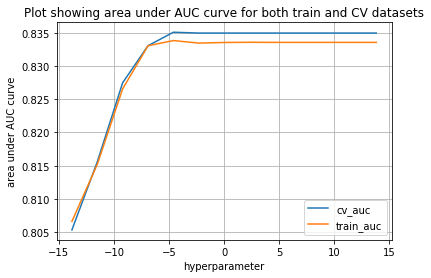

In [89]:
#plotting AUC score of Cross validation data and training data
plt.plot(log_c,cv_roc,label = 'cv_auc')
plt.plot(log_c,train_roc,label = 'train_auc')
plt.xlabel('hyperparameter')
plt.ylabel('area under AUC curve')
plt.title("Plot showing area under AUC curve for both train and CV datasets")
plt.grid()
plt.legend()
plt.show()

## Observation
<pre>We can see from above plot that as value of C increases our model is getting more and more underfitted. This is because the area under ROC curve for CV dataset is increasing at the faster rate as compared to area under ROC curve for training dataset. This means as C increases the performance of  model is increasing at faster rate on CV dataset as compared to performance of same model on training dataset and hence we are underfitting to training dataset as C increases.</pre>

In [90]:
#From above we found the best value of C = 0.01. Therefor we will now test our model on our test dataset.
lr = LogisticRegression(penalty = 'l2',C=0.01)
lr.fit(standardized_train,y_train)
pred = lr.predict(standardized_test)
print('For C = {0} the area under AUC curve is = {1}\n'.format(0.01,roc_auc_score(y_test, pred)))

For C = 0.01 the area under AUC curve is = 0.8323751386443894



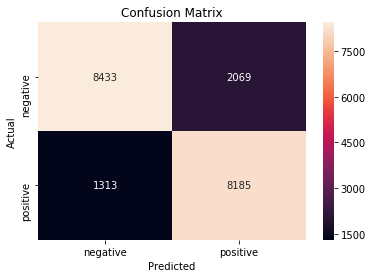

_____________________________________________________________________________________________________

For C = 0.01, the TPR = 86.17603706043377, TNR = 80.2989906684441, FPR = 19.701009331555895, FNR = 13.823962939566226


In [91]:
#plotting our confusion matrix
co_mt = confusion_matrix(y_test,pred)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(co_mt, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)
TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100# calculating TNR, TPR, FPR, FNR
FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
print('\nFor C = {0}, the TPR = {1}, TNR = {2}, FPR = {3}, FNR = {4}'.format(0.01,TPR,TNR,FPR,FNR))

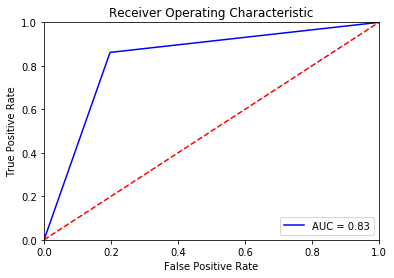

In [92]:
#plotting ROC curve for y_test
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)#roc_curve returns true positive rates and false positive rates for y-test
roc_auc = metrics.auc(fpr, tpr)#computes area under roc_curve using trapezoidal rule or in other words we can say using inte-
#-gration
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])#limiting values of x-axis between 0 and 1
plt.ylim([0, 1])#limiting values of y-axis between 0 and 1
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Observation:
<pre>As area under ROC curve > 50% therefore our model is better than simple mean model.</pre>

## 4.2 Weighted Word2Vec

In [93]:
#tf-idf on train dataset
vectorizer = TfidfVectorizer()#defining our tf-idf model and considering only those words which occur more than 50-
#times in our document
model = vectorizer.fit(x_train)#Here we are learning the internal parameters (i.e vocabulary) of our train dataset-
#- (i.e. review text)
print(vectorizer.vocabulary_) #visualizing the parameters learnt (i.e vocabulary)

{'presoak': 20374, 'institution': 13253, 'wave': 28759, 'eeekkk': 8197, 'coffeem': 5251, 'koenig': 14299, 'topic': 26735, 'muffl': 17050, 'tnereaft': 26581, 'fumbl': 10318, 'improvememnt': 12884, 'flavigni': 9683, 'dreari': 7833, 'nothin': 17810, 'inherit': 13157, 'kookaburra': 14336, 'scavang': 22804, 'ashtray': 1486, 'mirin': 16528, 'yucki': 29727, 'piana': 19605, 'chai': 4344, 'synthent': 25679, 'enterococcus': 8565, 'appley': 1231, 'sucr': 25252, 'pistaci': 19744, 'madelein': 15457, 'spurt': 24596, 'patend': 19111, 'quadroppl': 20935, 'gotta': 11079, 'girlfriend': 10763, 'pleas': 19870, 'trailmix': 26875, 'hubburd': 12486, 'nathan': 17308, 'constuct': 5675, 'tire': 26548, 'buffalo': 3423, 'loam': 15088, 'intl': 13342, 'artifici': 1444, 'cholestrol': 4787, 'strawberyy': 25014, 'mccall': 15965, 'fight': 9494, 'furbal': 10348, 'wds': 28778, 'soledad': 24136, 'boxload': 3077, 'dumpl': 7968, 'societi': 24078, 'sazon': 22754, 'wiener': 29127, 'grammat': 11141, 'qick': 20923, 'tesco': 261

In [94]:
#creating dictionary, where keys are words in our dataset and values are their corresponding idf values
dictionary_1 = dict(zip(model.get_feature_names(),list(model.idf_)))

In [95]:
#Weighted word2vec for x_train
tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary_1[word]*(sent.count(word)/len(sent)) # dictionary[word] = idf value of word in whole courpus-
            #- sent.count(word) = tf valeus of word in this review 
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_train))
print(len(tfidf_sent_vectors_train[0]))

100%|██████████| 60000/60000 [07:36<00:00, 131.36it/s]

60000
50


In [96]:
#Weighted word2vec for x_cv
tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary_1[word]*(sent.count(word)/len(sent)) # dictionary[word] = idf value of word in whole courpus-
            #- sent.count(word) = tf valeus of word in this review 
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_cv))
print(len(tfidf_sent_vectors_cv[0]))

100%|██████████| 20000/20000 [02:28<00:00, 134.82it/s]

20000
50


In [97]:
#Weighted word2vec for x_test
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary_1[word]*(sent.count(word)/len(sent)) # dictionary[word] = idf value of word in whole courpus-
            #- sent.count(word) = tf valeus of word in this review 
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_test))
print(len(tfidf_sent_vectors_test[0]))

100%|██████████| 20000/20000 [02:28<00:00, 134.58it/s]

20000
50


In [98]:
#here we are first creating a dataframes out of tfidf_sent_vectors_train, tfidf_sent_vectors_cv and tfidf_sent_vectors_test
tfidf_w2v_tr = pd.DataFrame(tfidf_sent_vectors_train)
tfidf_w2v_cv = pd.DataFrame(tfidf_sent_vectors_cv)
tfidf_w2v_te = pd.DataFrame(tfidf_sent_vectors_test)

In [99]:
#standardizing the dataframes created above
standardized_train = StandardScaler().fit_transform(tfidf_w2v_tr)
standardized_cv = StandardScaler().fit_transform(tfidf_w2v_cv)
standardized_test = StandardScaler().fit_transform(tfidf_w2v_te)

## [4.2.1] Logistic Regression on TFIDF W2V

### [4.2.1.1] Applying Logistic Regression with L1 regularization on TFIDF W2V

In [100]:
#Here we are trying to find area under AUC score along with Confusion matrix for train dataset for various values of-
#- C using Logistic Regression
train_roc = []
C = [10**6,10**5,10**4,10**3,10**2,10,1,10**-1,10**-2,10**-3,10**-4,10**-5,10**-6]
for i in C:
    lr = LogisticRegression(penalty = 'l1',C=i)
    lr.fit(standardized_train,y_train)
    pred = lr.predict(standardized_train)
    train_roc.append(roc_auc_score(y_train, pred))#roc_auc_score calculates area under the roc curve 

In [101]:
#performing simple cross validation using Logistic Regression for various values of C. Our metrics are-
#- area under auc curve and Confusion matrix
cv_roc = []
C = [10**6,10**5,10**4,10**3,10**2,10,1,10**-1,10**-2,10**-3,10**-4,10**-5,10**-6]
for i in C:
    lr = LogisticRegression(penalty = 'l1',C=i)
    lr.fit(standardized_train,y_train)
    pred = lr.predict(standardized_cv)
    cv_roc.append(roc_auc_score(y_cv, pred))
    co_mt = confusion_matrix(y_cv,pred)
    TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100# calculating TNR, TPR, FPR, FNR
    FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
    TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
    FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100  
    print('\nFor C = {0}, the area under AUC curve is = {1}, the TPR = {2}, TNR = {3}, FPR = {4}, FNR = {5}'.format(i,roc_auc_score(y_cv, pred),TPR,TNR,FPR,FNR))


For C = 1000000, the area under AUC curve is = 0.8012640901771335, the TPR = 84.45652173913044, TNR = 75.79629629629629, FPR = 24.203703703703706, FNR = 15.543478260869565

For C = 100000, the area under AUC curve is = 0.8012640901771335, the TPR = 84.45652173913044, TNR = 75.79629629629629, FPR = 24.203703703703706, FNR = 15.543478260869565

For C = 10000, the area under AUC curve is = 0.8012640901771335, the TPR = 84.45652173913044, TNR = 75.79629629629629, FPR = 24.203703703703706, FNR = 15.543478260869565

For C = 1000, the area under AUC curve is = 0.8012640901771335, the TPR = 84.45652173913044, TNR = 75.79629629629629, FPR = 24.203703703703706, FNR = 15.543478260869565

For C = 100, the area under AUC curve is = 0.8012640901771335, the TPR = 84.45652173913044, TNR = 75.79629629629629, FPR = 24.203703703703706, FNR = 15.543478260869565

For C = 10, the area under AUC curve is = 0.8012640901771335, the TPR = 84.45652173913044, TNR = 75.79629629629629, FPR = 24.203703703703706, FN

## Observation:
<pre>As we can see from above that we are getting maximum value of AUC for C = 0.01 , therefore we will choose that value of C as our hyperparameter value.</pre>

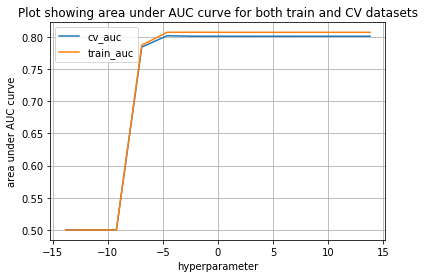

In [102]:
#plotting AUC score of Cross validation data and training data
plt.plot(log_c,cv_roc,label = 'cv_auc')
plt.plot(log_c,train_roc,label = 'train_auc')
plt.xlabel('hyperparameter')
plt.ylabel('area under AUC curve')
plt.title("Plot showing area under AUC curve for both train and CV datasets")
plt.grid()
plt.legend()
plt.show()

## Observation
<pre>We can see from above plot that as value of C increases our model is getting slightly overfitted. This is because the area under ROC curve for training dataset is slightly increasing at the faster rate as compared to area under ROC curve for CV dataset. This means as C increases the performance of  model is increasing slightly at faster rate on training dataset as compared to performance of same model on CV dataset and hence we are slightly overfitting to training dataset as C increases.</pre>

In [103]:
#From above we found the best value of C = 0.01. Therefor we will now test our model on our test dataset.
lr = LogisticRegression(penalty = 'l1',C=0.01)
lr.fit(standardized_train,y_train)
pred = lr.predict(standardized_test)
print('For C = {0} the area under AUC curve is = {1}\n'.format(0.01,roc_auc_score(y_test, pred)))

For C = 0.01 the area under AUC curve is = 0.8005339475692325



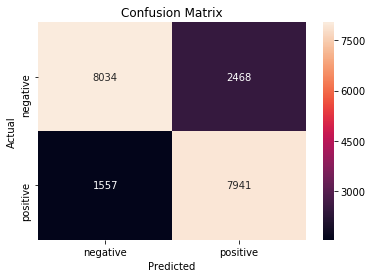

_____________________________________________________________________________________________________

For C = 0.01, the TPR = 83.60707517372077, TNR = 76.49971434012569, FPR = 23.500285659874308, FNR = 16.392924826279216


In [104]:
#plotting our confusion matrix
co_mt = confusion_matrix(y_test,pred)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(co_mt, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)
TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100# calculating TNR, TPR, FPR, FNR
FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
print('\nFor C = {0}, the TPR = {1}, TNR = {2}, FPR = {3}, FNR = {4}'.format(0.01,TPR,TNR,FPR,FNR))

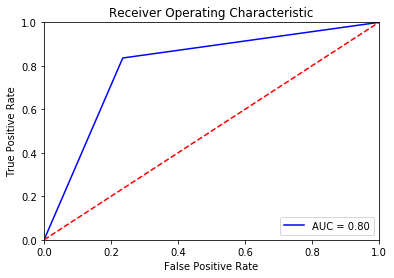

In [105]:
#plotting ROC curve for y_test
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)#roc_curve returns true positive rates and false positive rates for y-test
roc_auc = metrics.auc(fpr, tpr)#computes area under roc_curve using trapezoidal rule or in other words we can say using inte-
#-gration
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])#limiting values of x-axis between 0 and 1
plt.ylim([0, 1])#limiting values of y-axis between 0 and 1
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## observation:
<pre>As area under ROC curve > 50%, therefore our model is better than simple mean model.</pre>

### [4.2.1.2] Applying Logistic Regression with L2 regularization on TFIDF W2V

In [106]:
#Here we are trying to find area under AUC score along with Confusion matrix for train dataset for various values of-
#- C using Logistic Regression
train_roc = []
C = [10**6,10**5,10**4,10**3,10**2,10,1,10**-1,10**-2,10**-3,10**-4,10**-5,10**-6]
for i in C:
    lr = LogisticRegression(penalty = 'l2',C=i)
    lr.fit(standardized_train,y_train)
    pred = lr.predict(standardized_train)
    train_roc.append(roc_auc_score(y_train, pred))#roc_auc_score calculates area under the roc curve 

In [107]:
#performing simple cross validation using Logistic Regression for various values of C. Our metrics are-
#- area under auc curve and Confusion matrix
cv_roc = []
C = [10**6,10**5,10**4,10**3,10**2,10,1,10**-1,10**-2,10**-3,10**-4,10**-5,10**-6]
for i in C:
    lr = LogisticRegression(penalty = 'l2',C=i)
    lr.fit(standardized_train,y_train)
    pred = lr.predict(standardized_cv)
    cv_roc.append(roc_auc_score(y_cv, pred))
    co_mt = confusion_matrix(y_cv,pred)
    TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100# calculating TNR, TPR, FPR, FNR
    FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
    TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
    FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100  
    print('\nFor C = {0}, the area under AUC curve is = {1}, the TPR = {2}, TNR = {3}, FPR = {4}, FNR = {5}'.format(i,roc_auc_score(y_cv, pred),TPR,TNR,FPR,FNR))


For C = 1000000, the area under AUC curve is = 0.8012640901771335, the TPR = 84.45652173913044, TNR = 75.79629629629629, FPR = 24.203703703703706, FNR = 15.543478260869565

For C = 100000, the area under AUC curve is = 0.8012640901771335, the TPR = 84.45652173913044, TNR = 75.79629629629629, FPR = 24.203703703703706, FNR = 15.543478260869565

For C = 10000, the area under AUC curve is = 0.8012640901771335, the TPR = 84.45652173913044, TNR = 75.79629629629629, FPR = 24.203703703703706, FNR = 15.543478260869565

For C = 1000, the area under AUC curve is = 0.8012640901771335, the TPR = 84.45652173913044, TNR = 75.79629629629629, FPR = 24.203703703703706, FNR = 15.543478260869565

For C = 100, the area under AUC curve is = 0.8012640901771335, the TPR = 84.45652173913044, TNR = 75.79629629629629, FPR = 24.203703703703706, FNR = 15.543478260869565

For C = 10, the area under AUC curve is = 0.8012640901771335, the TPR = 84.45652173913044, TNR = 75.79629629629629, FPR = 24.203703703703706, FN

## Observation:
<pre>As we can see from above that we are getting maximum value of AUC for C = 0.001, therefore we will choose that value of C as our hyperparameter value.</pre>

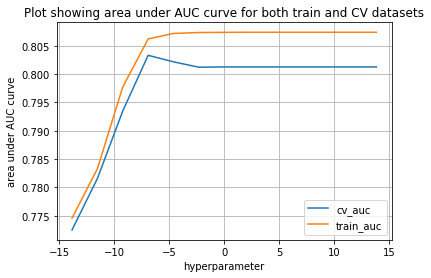

In [108]:
#plotting AUC score of Cross validation data and training data
plt.plot(log_c,cv_roc,label = 'cv_auc')
plt.plot(log_c,train_roc,label = 'train_auc')
plt.xlabel('hyperparameter')
plt.ylabel('area under AUC curve')
plt.title("Plot showing area under AUC curve for both train and CV datasets")
plt.grid()
plt.legend()
plt.show()

## Observation
<pre>We can see from above plot that as value of C increases our model is getting more and more overfitted. This is because the area under ROC curve for training dataset is increasing at the faster rate as compared to area under ROC curve for CV dataset. This means as C increases the performance of  model is increasing at faster rate on training dataset as compared to performance of same model on CV dataset and hence we are overfitting to training dataset as C increases.</pre>

In [109]:
#From above we found the best value of C = 0.001. Therefor we will now test our model on our test dataset.
lr = LogisticRegression(penalty = 'l2',C=0.001)
lr.fit(standardized_train,y_train)
pred = lr.predict(standardized_test)
print('For C = {0} the area under AUC curve is = {1}\n'.format(0.01,roc_auc_score(y_test, pred)))

For C = 0.01 the area under AUC curve is = 0.7995314211625865



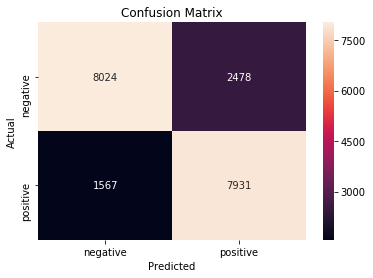

_____________________________________________________________________________________________________

For C = 0.001, the TPR = 83.50178985049484, TNR = 76.40449438202246, FPR = 23.595505617977526, FNR = 16.49821014950516


In [110]:
#plotting our confusion matrix
co_mt = confusion_matrix(y_test,pred)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(co_mt, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)
TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100# calculating TNR, TPR, FPR, FNR
FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
print('\nFor C = {0}, the TPR = {1}, TNR = {2}, FPR = {3}, FNR = {4}'.format(0.001,TPR,TNR,FPR,FNR))

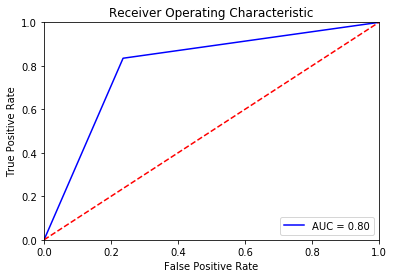

In [111]:
#plotting ROC curve for y_test
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)#roc_curve returns true positive rates and false positive rates for y-test
roc_auc = metrics.auc(fpr, tpr)#computes area under roc_curve using trapezoidal rule or in other words we can say using inte-
#-gration
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])#limiting values of x-axis between 0 and 1
plt.ylim([0, 1])#limiting values of y-axis between 0 and 1
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Observation:
<pre>We can see from above plot that area under ROC curve > 50% therefore our model is better than simple mean model.</pre>

# [5] Conclusions

In [114]:
list_1 = [['BOW','L1',0.01, 0.8657797997265029, 89.92419456727733,83.23176537802324,16.768234621976767,10.075805432722678],
         ['BOW','L2',0.0001,0.8633505779905593,90.61907770056854,82.05103789754332,17.948962102456676, 9.38092229943146],
         ['TFIDF','L1',0.01,0.8712936047356781,89.2082543693409,85.05046657779471,14.949533422205294,10.791745630659086],
         ['TFIDF','L2',0.001,0.8673992508080061,89.02926931985681,84.45058084174443,15.54941915825557,10.970730680143188],
         ['Average W2V','L1',0.1,0.8326658312012605,86.18656559275637,80.34660064749572,19.653399352504287,13.81343440724363],
         ['Average W2V','L2',0.01,0.8323751386443894,86.17603706043377,80.2989906684441,19.701009331555895,13.823962939566226],
         ['Weighted W2V','L1',0.01,0.8005339475692325,83.60707517372077,76.49971434012569,23.500285659874308,16.392924826279216],
         ['Weighted W2V','L2',0.01,0.7995314211625865,83.50178985049484,76.40449438202246,23.595505617977526,16.49821014950516]]
columns= ['Vectorizer', 'Regualrizer', 'Hyperparameter','AUC', 'TPR','TNR','FPR','FNR' ]
pd.DataFrame(list_1,columns = columns)

,Vectorizer,Regualrizer,Hyperparameter,AUC,TPR,TNR,FPR,FNR
0,BOW,L1,0.0100,0.865780,89.924195,83.231765,16.768235,10.075805
1,BOW,L2,0.0001,0.863351,90.619078,82.051038,17.948962,9.380922
2,TFIDF,L1,0.0100,0.871294,89.208254,85.050467,14.949533,10.791746
3,TFIDF,L2,0.0010,0.867399,89.029269,84.450581,15.549419,10.970731
4,Average W2V,L1,0.1000,0.832666,86.186566,80.346601,19.653399,13.813434
5,Average W2V,L2,0.0100,0.832375,86.176037,80.298991,19.701009,13.823963
6,Weighted W2V,L1,0.0100,0.800534,83.607075,76.499714,23.500286,16.392925
7,Weighted W2V,L2,0.0100,0.799531,83.501790,76.404494,23.595506,16.498210


<pre>1. We can see from above table that Logistic Regression with L1 regularizer performs best on TFIDF vector representation of our reviews in determining whether a review is positive or not.</pre>
<pre>2. Logistic Regression + L1 regularizer + TFIDF vector representation also gives us the least biased model.</pre>
<pre>3. On the basis of AUC score, our models from best to worst are as follows:
<b>Logistic Regression + L1 regularizer + TFIDF > Logistic Regression + L2 regularizer + TFIDF > Logistic Regression + L1 regularizer + BOW > Logistic Regression + L2 regularizer + BOW > Logistic Regression + L1 regularizer + Avg W2V > Logistic Regression + L2 regularizer + Avg W2V > Logistic Regression + L1 regularizer + Weighted W2V > Logistic Regression + L2 regularizer + Weighted W2V</b></pre>